# Basic Conditional GAN (Using Mnist image data)
 **Hung-yi Lee Video:  
 https://www.youtube.com/watch?v=LpyL4nZSuqU&feature=youtu.be

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read mnist data
**Download 'mnist.npz' from: https://s3.amazonaws.com/img-datasets/mnist.npz

** Or using coding below :      
import tensorflow as tf      
mnist = tf.keras.datasets.mnist     
(x_train, y_train),(x_test, y_test) = mnist.load_data()     
x_train, x_test = x_train / 255.0, x_test / 255.0   


In [2]:
def one_hot(data):
    '''Label convert to onehot!!'''
    one_hot = np.zeros((data.shape[0], 10))
    one_hot[np.arange(data.shape[0]), data] = 1
    return one_hot

In [3]:
mnist_data = np.load('mnist.npz')

x_test = mnist_data['x_test'].reshape((-1, 784)) 
x_train = mnist_data['x_train'].reshape((-1, 784))
y_train = one_hot(mnist_data['y_train'])
y_test = one_hot(mnist_data['y_test'])


x_train, x_test = x_train / 255.0, x_test / 255.0
mb_size = 60
Z_dim = 784
X_dim = x_train.shape[1]
y_dim = y_train.shape[1]
h_dim = 128

In [4]:
# check data shape
print("X_train data shape: ", x_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_test data shape: ", x_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (60000, 784)
y_train data shape:  (60000, 10)
X_test data shape:  (10000, 784)
y_test data shape:  (10000, 10)


# Function to show imagine

In [5]:
def plot(samples):
    '''Function to show image'''
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

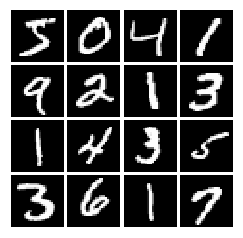

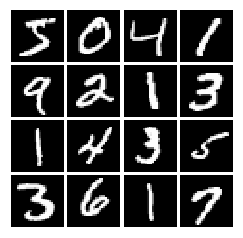

In [6]:
#Plot date
plot(x_train[0:16])

# Building Conditional GAN Model

In [7]:
def xavier_init(size):
    ''' Function for initializing the weight value by normal distribution'''
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [8]:
""" Discriminator Net model:
     - Input  : real & fake + label
     - Output : one number, mean real or fake
"""
# input:  image & label
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])


# Weights & bias of  first layer
D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))


# Weights & bias of  second layer
# output one value, mean real of fake
D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1])) 

#???
theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    ''' combine two layers !'''
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

In [9]:
""" Generator Net model:
     - Input  : random noise vector 
     - Output : Create one image as real as possible
"""
# input: image shape
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

# Weights & bias of  first layer
G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# Weights & bias of  second layer
# output one one image
G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    ''' combine two layers !'''
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

In [10]:
""" Call function to building model"""
G_sample = generator(Z, y)# model G
D_real, D_logit_real = discriminator(X, y) # model D

# G create fake image &  D day the image is real of fake
D_fake, D_logit_fake = discriminator(G_sample, y) 

In [11]:
# Building loss function
D_loss_real = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(
                       logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(
                       logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))


# Optimizer by gradient decent
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# Run model

In [12]:
def sample_Z(m, n):
    '''Function to create random noise'''
    return np.random.uniform(-1., 1., size=[m, n])

In [13]:

with tf.Session() as sess:
#sess = tf.Session() # prepare take the model(calculate graph)
    sess.run(tf.global_variables_initializer()) # initializing whole tensorflow variabel


    if not os.path.exists('out/'):
        os.makedirs('out/')
    if not os.path.exists('./model_saved/'):
        os.makedirs('./model_saved/')


    i = 0
    for it in range(1000000):
        # take the range of each batch size
        data_start = it*mb_size%60000
        data_end = (it+1)*mb_size%60000
        if data_end == 0: continue

        # Shoe G model output image
        if it % 1000 == 0:
            n_sample = 16

            Z_sample = sample_Z(n_sample, Z_dim) # random noise
            y_sample = np.zeros(shape=[n_sample, y_dim]) 
            y_sample[:, 7] = 1

            # Run G & give the input
            samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

            fig = plot(samples)
            plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

        #     
        if it % 2000==0:
            data = {v.name: v.eval() for v in tf.global_variables()}
            save_path = os.path.join('./model_saved/', str(it))
            np.save(save_path, data)
            print('Lasest saved:', it)

        # take batch data
        X_mb = x_train[data_start:data_end, :]
        y_mb = y_train[data_start:data_end, :]

        Z_sample = sample_Z(mb_size, Z_dim) #random noise
        # Train D model & given the input(training data)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
        # Train G model & given the input(random noise)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()

Lasest saved: 0
Iter: 0
D loss: 1.419
G_loss: 2.687

Iter: 1000
D loss: 0.02821
G_loss: 5.025

Lasest saved: 2000
Iter: 2000
D loss: 0.1659
G_loss: 4.158

Iter: 3000
D loss: 0.247
G_loss: 4.249

Lasest saved: 4000
Iter: 4000
D loss: 0.347
G_loss: 6.137

Iter: 5000
D loss: 0.1694
G_loss: 4.533

Lasest saved: 6000
Iter: 6000
D loss: 0.6128
G_loss: 4.208

Iter: 7000
D loss: 0.5618
G_loss: 3.986

Lasest saved: 8000
Iter: 8000
D loss: 1.014
G_loss: 3.823

Iter: 9000
D loss: 0.6568
G_loss: 3.394

Lasest saved: 10000
Iter: 10000
D loss: 0.8919
G_loss: 3.423

Iter: 11000
D loss: 0.6213
G_loss: 3.258

Lasest saved: 12000
Iter: 12000
D loss: 0.7359
G_loss: 2.324

Iter: 13000
D loss: 1.038
G_loss: 1.988

Lasest saved: 14000
Iter: 14000
D loss: 0.8725
G_loss: 2.235

Iter: 15000
D loss: 0.651
G_loss: 2.411

Lasest saved: 16000
Iter: 16000
D loss: 1.046
G_loss: 2.044

Iter: 17000
D loss: 0.8917
G_loss: 1.967

Lasest saved: 18000
Iter: 18000
D loss: 0.8851
G_loss: 2.079

Iter: 19000
D loss: 0.9128
G_

KeyboardInterrupt: 